# Reproducibility challenge
### Fundamentals of Inference and Learning, EE-411
#### Thomas Lenges, Renuka Singh Virk

In this notebook, we attempt to reproduce the double descent curves from the paper "Reconciling modern machine learning practice and the bias-variance trade-of" by $\textit{Mikhail Belkin}$, $\textit{Daniel Hsu}$, $\textit{Siyuan Ma}$, $\textit{Soumik Mandal}$.

### Audio
The code below is to get a sound when a cell finishes running :)

In [1]:
from google.colab import files

# Upload your audio file (choose a .mp3 or .wav file)
uploaded = files.upload()


ModuleNotFoundError: No module named 'google.colab'

In [32]:
from IPython.display import Audio, display

# Play the uploaded audio file
sound = Audio("result.wav", autoplay=True)  # Replace 'beep.wav' with your uploaded filename

## Double descent risk curve for RFF model on MNIST.

In the following section, we reproduce the results of Figure 2 of the paper.

Section B, 'Experimental setup' of the paper provides insights on how the plots were generated.
As indicated in Figure 2, the authors of the paper used a subset of the MNIST dataset ($n=10^4$, $10$ classes).

The steps to apply are the following:
- Transform images to grayscale images (not necessary for MNIST as it is already grayscale)
- Scale the maximum range of each feature to $[0,1]$
- Perform one-hot encoding
- Subsample a training set (size $n$) uniformly at random without replacement

Note that the number of random fourier features in Figure 2 ranges from $0$ to $60000$, however our system crashes for $n=40000$ or $n=60000$, which is why we limit to $20000$. However this should be sufficient to conclude whetheru the figure was reproduced properly or not.

Import libraries, datasets and define useful functions:

In [17]:
# Imports
import numpy as np
import torch
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import torch.nn.functional as F

In [9]:
# Hyperparameters
num_training_data = 10000 # Subsample size
num_test_data = 10000     # Use the full MNIST test set
num_classes = 10          # Number of classes
regularization = 0.001    # Regularization strength
sigma = 5.0               # Bandwidth for Gaussian kernel
num_rff = [200, 500, 1000, 1500, 2000, 5000, 10000, 20000] #, 40000]  # RFF dimensions
seed = 42                 # Random seed for reproducibility

# Set random seed
np.random.seed(seed)
torch.manual_seed(seed)

In [10]:
# Data Preprocessing: Load MNIST
def preprocess_mnist():
    transform = transforms.Compose([
        transforms.ToTensor(),                      # Scale to [0, 1]
        transforms.Lambda(lambda x: x.view(-1))     # Flatten image
    ])

    # Load MNIST dataset
    mnist_train = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
    mnist_test = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

    # Subsample training data
    indices = np.random.choice(len(mnist_train), num_training_data, replace=False)
    train_subset = torch.utils.data.Subset(mnist_train, indices)
    train_loader = torch.utils.data.DataLoader(train_subset, batch_size=num_training_data, shuffle=False)

    test_loader = torch.utils.data.DataLoader(mnist_test, batch_size=num_test_data, shuffle=False)

    # Extract training and test data
    x_train, y_train = next(iter(train_loader))
    x_test, y_test = next(iter(test_loader))

    # One-hot encode labels
    y_train_onehot = torch.nn.functional.one_hot(y_train, num_classes=num_classes).float()
    y_test_onehot = torch.nn.functional.one_hot(y_test, num_classes=num_classes).float()

    return x_train, y_train_onehot, x_test, y_test_onehot

x_train, y_train, x_test, y_test = preprocess_mnist()

In [11]:
# Generate Random Fourier Features (RFF)
def generate_rff(x, D, d, sigma):
    weights = torch.randn(D, d // 2) * (1 / sigma)
    projection = x @ weights
    rff_features = torch.cat([torch.sin(projection), torch.cos(projection)], dim=-1)
    return rff_features

# Train using RFF
def train_rff(x_train, y_train, x_test, y_test, d, regularization, sigma):
    # Generate RFF features
    rff_train = generate_rff(x_train, x_train.shape[1], d, sigma)
    rff_test = generate_rff(x_test, x_train.shape[1], d, sigma)

    # Solve linear system to find weights
    A = rff_train.T @ rff_train + regularization * torch.eye(d)
    b = rff_train.T @ y_train
    alpha = torch.linalg.solve(A, b)

    # Predictions
    y_train_pred = rff_train @ alpha
    y_test_pred = rff_test @ alpha

    # Compute classification error
    train_error = 100.0 - (torch.argmax(y_train_pred, dim=1) == torch.argmax(y_train, dim=1)).float().mean().item() * 100
    test_error = 100.0 - (torch.argmax(y_test_pred, dim=1) == torch.argmax(y_test, dim=1)).float().mean().item() * 100

    return train_error, test_error


In [12]:
# Generate results
train_errors = []
test_errors = []

for d in num_rff:
    print(f"Training with {d} random Fourier features...")
    train_error, test_error = train_rff(x_train, y_train, x_test, y_test, d, regularization, sigma)
    train_errors.append(train_error)
    test_errors.append(test_error)

Training with 200 random Fourier features...
Training with 500 random Fourier features...
Training with 1000 random Fourier features...
Training with 1500 random Fourier features...
Training with 2000 random Fourier features...
Training with 5000 random Fourier features...
Training with 10000 random Fourier features...
Training with 20000 random Fourier features...


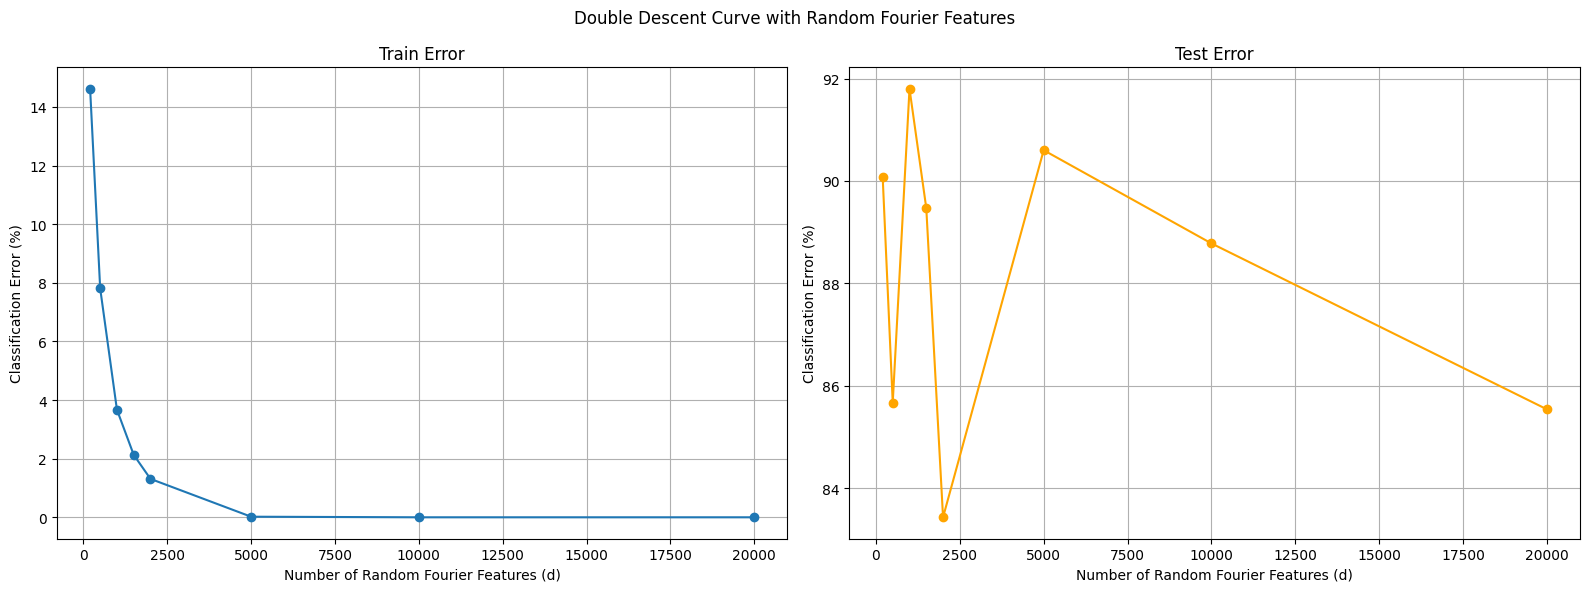

In [13]:
# Plot Results
fig, axs = plt.subplots(1, 2, figsize=(16, 6))

# Train Error Plot
axs[0].plot(num_rff, train_errors, label='Train Error', marker='o')
axs[0].set_xlabel('Number of Random Fourier Features (d)')
axs[0].set_ylabel('Classification Error (%)')
axs[0].set_title('Train Error')
axs[0].grid()

# Test Error Plot
axs[1].plot(num_rff, test_errors, label='Test Error', marker='o', color='orange')
axs[1].set_xlabel('Number of Random Fourier Features (d)')
axs[1].set_ylabel('Classification Error (%)')
axs[1].set_title('Test Error')
axs[1].grid()

plt.suptitle('Double Descent Curve with Random Fourier Features')
plt.tight_layout()
plt.show()


In [22]:
# Compute Random Fourier Features (RFF)
def generate_rff(x, D, d, sigma):
    weights = torch.randn(D, d // 2) * (1 / sigma)
    projection = x @ weights
    rff_features = torch.cat([torch.sin(projection), torch.cos(projection)], dim=-1)
    return rff_features

# Train and Evaluate with RFF
def train_evaluate_rff(x_train, y_train, x_test, y_test, d, regularization, sigma):
    # Generate RFF
    rff_train = generate_rff(x_train, x_train.shape[1], d, sigma)
    rff_test = generate_rff(x_test, x_train.shape[1], d, sigma)

    # Solve for weights using regularized least squares
    A = rff_train.T @ rff_train + regularization * torch.eye(d)
    b = rff_train.T @ y_train
    weights = torch.linalg.solve(A, b)

    # Predictions
    y_train_pred = rff_train @ weights
    y_test_pred = rff_test @ weights

    # Zero-One Loss
    train_zero_one_error = 100 - (torch.argmax(y_train_pred, dim=1) == torch.argmax(y_train, dim=1)).float().mean().item() * 100
    test_zero_one_error = 100 - (torch.argmax(y_test_pred, dim=1) == torch.argmax(y_test, dim=1)).float().mean().item() * 100

    # Squared Loss
    train_squared_loss = F.mse_loss(y_train_pred, y_train).item()
    test_squared_loss = F.mse_loss(y_test_pred, y_test).item()

    # Norm of the Solution
    norm = torch.norm(weights).item()

    return train_zero_one_error, test_zero_one_error, train_squared_loss, test_squared_loss, norm

# Main Function to Generate Results
def main():
    # Hyperparameters
    num_training_data = 10000
    num_test_data = 10000
    num_classes = 10
    regularization = 0.001
    sigma = 5.0
    d_values = [500, 1000, 2000, 5000, 10000, 20000]#, 60000]

    # Dummy Data (Replace with Actual Data)
    x_train = torch.randn(num_training_data, 784)  # Replace with actual MNIST/CIFAR-10 flattened data
    y_train = F.one_hot(torch.randint(0, num_classes, (num_training_data,)), num_classes).float()
    x_test = torch.randn(num_test_data, 784)      # Replace with actual test data
    y_test = F.one_hot(torch.randint(0, num_classes, (num_test_data,)), num_classes).float()

    # Store Results
    train_zero_one_errors = []
    test_zero_one_errors = []
    train_squared_losses = []
    test_squared_losses = []
    norms = []

    # Loop over d values
    for d in num_rff:
        print(f"Training with d = {d}...")
        results = train_evaluate_rff(x_train, y_train, x_test, y_test, d, regularization, sigma)
        train_zero_one_errors.append(results[0])
        test_zero_one_errors.append(results[1])
        train_squared_losses.append(results[2])
        test_squared_losses.append(results[3])
        norms.append(results[4])

    # Plot Results
    fig, axs = plt.subplots(3, 2, figsize=(16, 18))

    # Zero-One Loss (Left Column)
    axs[0, 0].plot(num_rff, test_zero_one_errors, label='Test Error (%)', marker='o')
    axs[0, 0].set_title('Test Error (Zero-One Loss)')
    axs[0, 0].set_xlabel('Number of Random Fourier Features (d)')
    axs[0, 0].set_ylabel('Error (%)')
    axs[0, 0].grid()

    axs[1, 0].plot(num_rff, norms, label='Norm of Solution', marker='o')
    axs[1, 0].set_title('Norm of Solution (Zero-One Loss)')
    axs[1, 0].set_xlabel('Number of Random Fourier Features (d)')
    axs[1, 0].set_ylabel('Norm')
    axs[1, 0].grid()

    axs[2, 0].plot(num_rff, train_zero_one_errors, label='Train Error (%)', marker='o')
    axs[2, 0].set_title('Train Error (Zero-One Loss)')
    axs[2, 0].set_xlabel('Number of Random Fourier Features (d)')
    axs[2, 0].set_ylabel('Error (%)')
    axs[2, 0].grid()

    # Squared Loss (Right Column)
    axs[0, 1].plot(num_rff, test_squared_losses, label='Test Squared Loss', marker='o', color='orange')
    axs[0, 1].set_title('Test Loss (Squared Loss)')
    axs[0, 1].set_xlabel('Number of Random Fourier Features (d)')
    axs[0, 1].set_ylabel('Loss')
    axs[0, 1].grid()

    axs[1, 1].plot(num_rff, norms, label='Norm of Solution', marker='o', color='green')
    axs[1, 1].set_title('Norm of Solution (Squared Loss)')
    axs[1, 1].set_xlabel('Number of Random Fourier Features (d)')
    axs[1, 1].set_ylabel('Norm')
    axs[1, 1].grid()

    axs[2, 1].plot(num_rff, train_squared_losses, label='Train Squared Loss', marker='o', color='red')
    axs[2, 1].set_title('Train Loss (Squared Loss)')
    axs[2, 1].set_xlabel('Number of Random Fourier Features (d)')
    axs[2, 1].set_ylabel('Loss')
    axs[2, 1].grid()

    plt.tight_layout()
    plt.show()

Training with d = 200...
Training with d = 500...
Training with d = 1000...
Training with d = 1500...
Training with d = 2000...
Training with d = 5000...
Training with d = 10000...
Training with d = 20000...


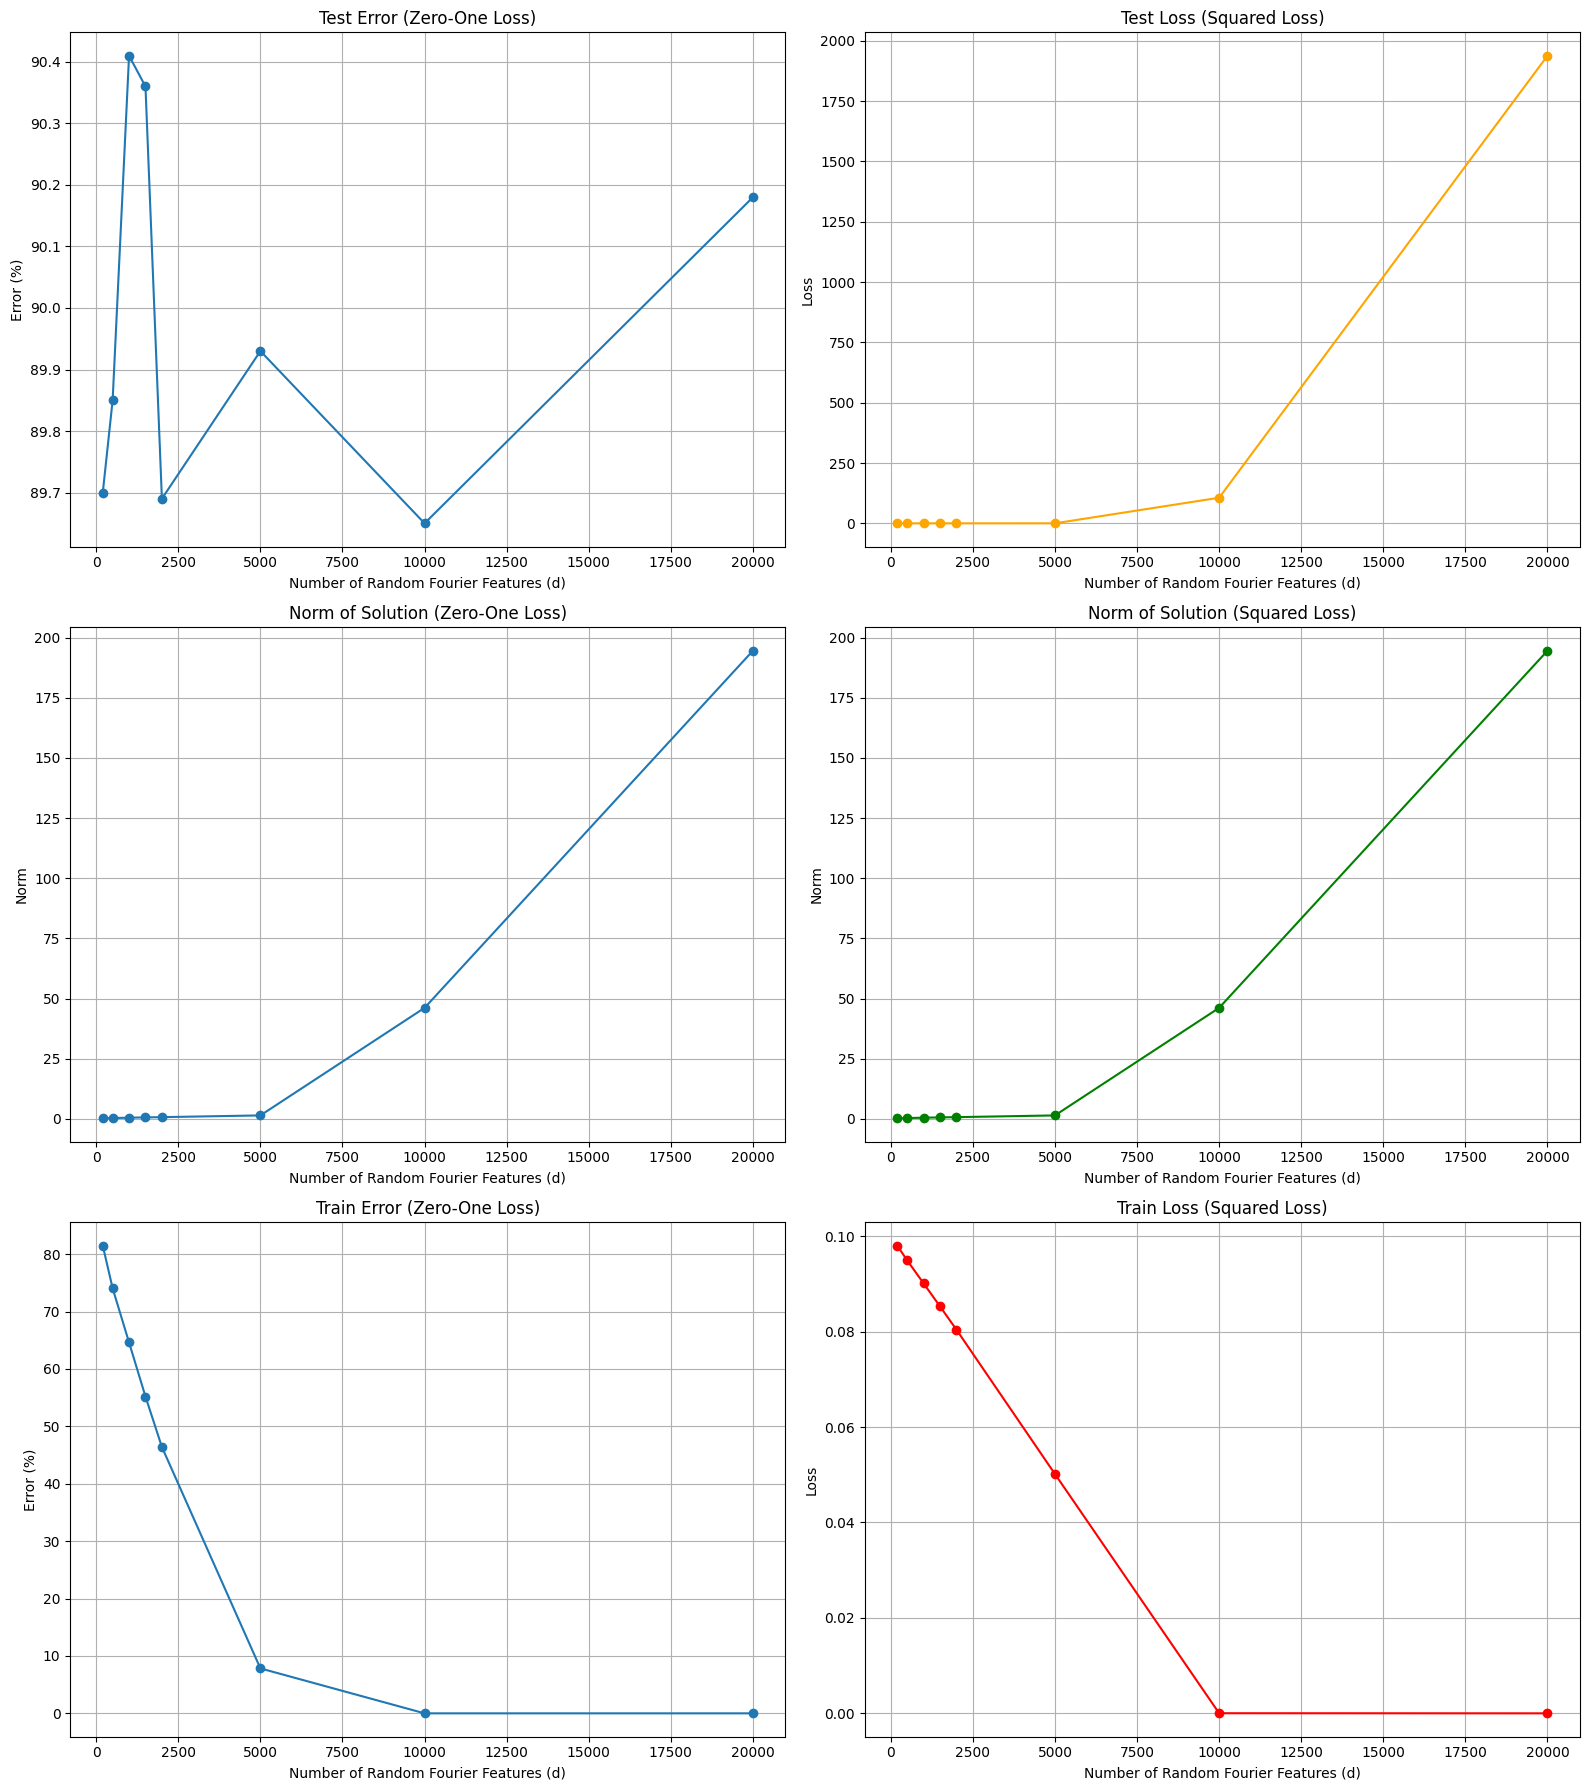

In [23]:
main()

In [35]:
display(sound)

In [37]:
# Train and Evaluate with RFF
def train_evaluate_rff(x_train, y_train, x_test, y_test, d, regularization, sigma):
    """Train RFF model and compute metrics."""
    # Generate RFF
    rff_train = generate_rff(x_train, x_train.shape[1], d, sigma)
    rff_test = generate_rff(x_test, x_train.shape[1], d, sigma)

    # Solve for weights using regularized least squares
    A = rff_train.T @ rff_train + regularization * torch.eye(d)
    b = rff_train.T @ y_train
    weights = torch.linalg.solve(A, b)

    # Predictions
    y_train_pred = rff_train @ weights
    y_test_pred = rff_test @ weights

    # Zero-One Loss
    train_zero_one_error = 100 - (torch.argmax(y_train_pred, dim=1) == torch.argmax(y_train, dim=1)).float().mean().item() * 100
    test_zero_one_error = 100 - (torch.argmax(y_test_pred, dim=1) == torch.argmax(y_test, dim=1)).float().mean().item() * 100

    # Squared Loss
    train_squared_loss = F.mse_loss(y_train_pred, y_train).item()
    test_squared_loss = F.mse_loss(y_test_pred, y_test).item()

    # Norm of the Solution
    norm = torch.norm(weights).item()

    return train_zero_one_error, test_zero_one_error, train_squared_loss, test_squared_loss, norm

# Main Function to Generate Results
def main():
    # Hyperparameters
    num_training_data = 10000
    num_test_data = 10000
    num_classes = 10
    regularization = 0.001
    sigma = 5.0
    d_values = [500, 1000, 2000, 5000, 10000, 20000, 60000]

    # Dummy Data (Replace with Actual Data)
    x_train = torch.randn(num_training_data, 784)  # Replace with MNIST flattened data
    y_train = torch.nn.functional.one_hot(torch.randint(0, num_classes, (num_training_data,)), num_classes).float()
    x_test = torch.randn(num_test_data, 784)      # Replace with actual test data
    y_test = torch.nn.functional.one_hot(torch.randint(0, num_classes, (num_test_data,)), num_classes).float()

    # Store Results
    train_zero_one_errors = []
    test_zero_one_errors = []
    train_squared_losses = []
    test_squared_losses = []
    norms = []

    # Loop over d values
    for d in num_rff:
        print(f"Training with d = {d}...")
        results = train_evaluate_rff(x_train, y_train, x_test, y_test, d, regularization, sigma)
        train_zero_one_errors.append(results[0])
        test_zero_one_errors.append(results[1])
        train_squared_losses.append(results[2])
        test_squared_losses.append(results[3])
        norms.append(results[4])

    # Plot Results
    fig, axs = plt.subplots(3, 2, figsize=(16, 18))

    # Zero-One Loss (Left Column)
    axs[0, 0].plot(num_rff, test_zero_one_errors, label='Test Risk', marker='o')
    axs[0, 0].set_yscale('log')
    axs[0, 0].axvline(x=10000, color='red', linestyle='--', label='Interpolation Threshold (N=10^4)')
    axs[0, 0].set_title('Test Risk (Zero-One Loss)')
    axs[0, 0].set_xlabel('Number of Random Fourier Features (d)')
    axs[0, 0].set_ylabel('Risk (log scale)')
    axs[0, 0].grid()

    axs[1, 0].plot(num_rff, norms, label='L2 Norm', marker='o')
    axs[1, 0].set_yscale('log')
    axs[1, 0].axvline(x=10000, color='red', linestyle='--', label='Interpolation Threshold (N=10^4)')
    axs[1, 0].set_title('L2 Norm of Solution (Zero-One Loss)')
    axs[1, 0].set_xlabel('Number of Random Fourier Features (d)')
    axs[1, 0].set_ylabel('L2 Norm (log scale)')
    axs[1, 0].grid()

    axs[2, 0].plot(num_rff, train_zero_one_errors, label='Train Risk', marker='o')
    axs[2, 0].set_yscale('log')
    axs[2, 0].axvline(x=10000, color='red', linestyle='--', label='Interpolation Threshold (N=10^4)')
    axs[2, 0].set_title('Train Risk (Zero-One Loss)')
    axs[2, 0].set_xlabel('Number of Random Fourier Features (d)')
    axs[2, 0].set_ylabel('Risk (log scale)')
    axs[2, 0].grid()

    # Squared Loss (Right Column)
    axs[0, 1].plot(num_rff, test_squared_losses, label='Test Risk', marker='o', color='orange')
    axs[0, 1].set_yscale('log')
    axs[0, 1].axvline(x=10000, color='red', linestyle='--', label='Interpolation Threshold (N=10^4)')
    axs[0, 1].set_title('Test Risk (Squared Loss)')
    axs[0, 1].set_xlabel('Number of Random Fourier Features (d)')
    axs[0, 1].set_ylabel('Risk (log scale)')
    axs[0, 1].grid()

    axs[1, 1].plot(num_rff, norms, label='L2 Norm', marker='o', color='green')
    axs[1, 1].set_yscale('log')
    axs[1, 1].axvline(x=10000, color='red', linestyle='--', label='Interpolation Threshold (N=10^4)')
    axs[1, 1].set_title('L2 Norm of Solution (Squared Loss)')
    axs[1, 1].set_xlabel('Number of Random Fourier Features (d)')
    axs[1, 1].set_ylabel('L2 Norm (log scale)')
    axs[1, 1].grid()

    axs[2, 1].plot(num_rff, train_squared_losses, label='Train Risk', marker='o', color='red')
    axs[2, 1].set_yscale('log')
    axs[2, 1].axvline(x=10000, color='red', linestyle='--', label='Interpolation Threshold (N=10^4)')
    axs[2, 1].set_title('Train Risk (Squared Loss)')
    axs[2, 1].set_xlabel('Number of Random Fourier Features (d)')
    axs[2, 1].set_ylabel('Risk (log scale)')
    axs[2, 1].grid()

    plt.tight_layout()
    plt.show()

Training with d = 200...
Training with d = 500...
Training with d = 1000...
Training with d = 1500...
Training with d = 2000...
Training with d = 5000...
Training with d = 10000...
Training with d = 20000...


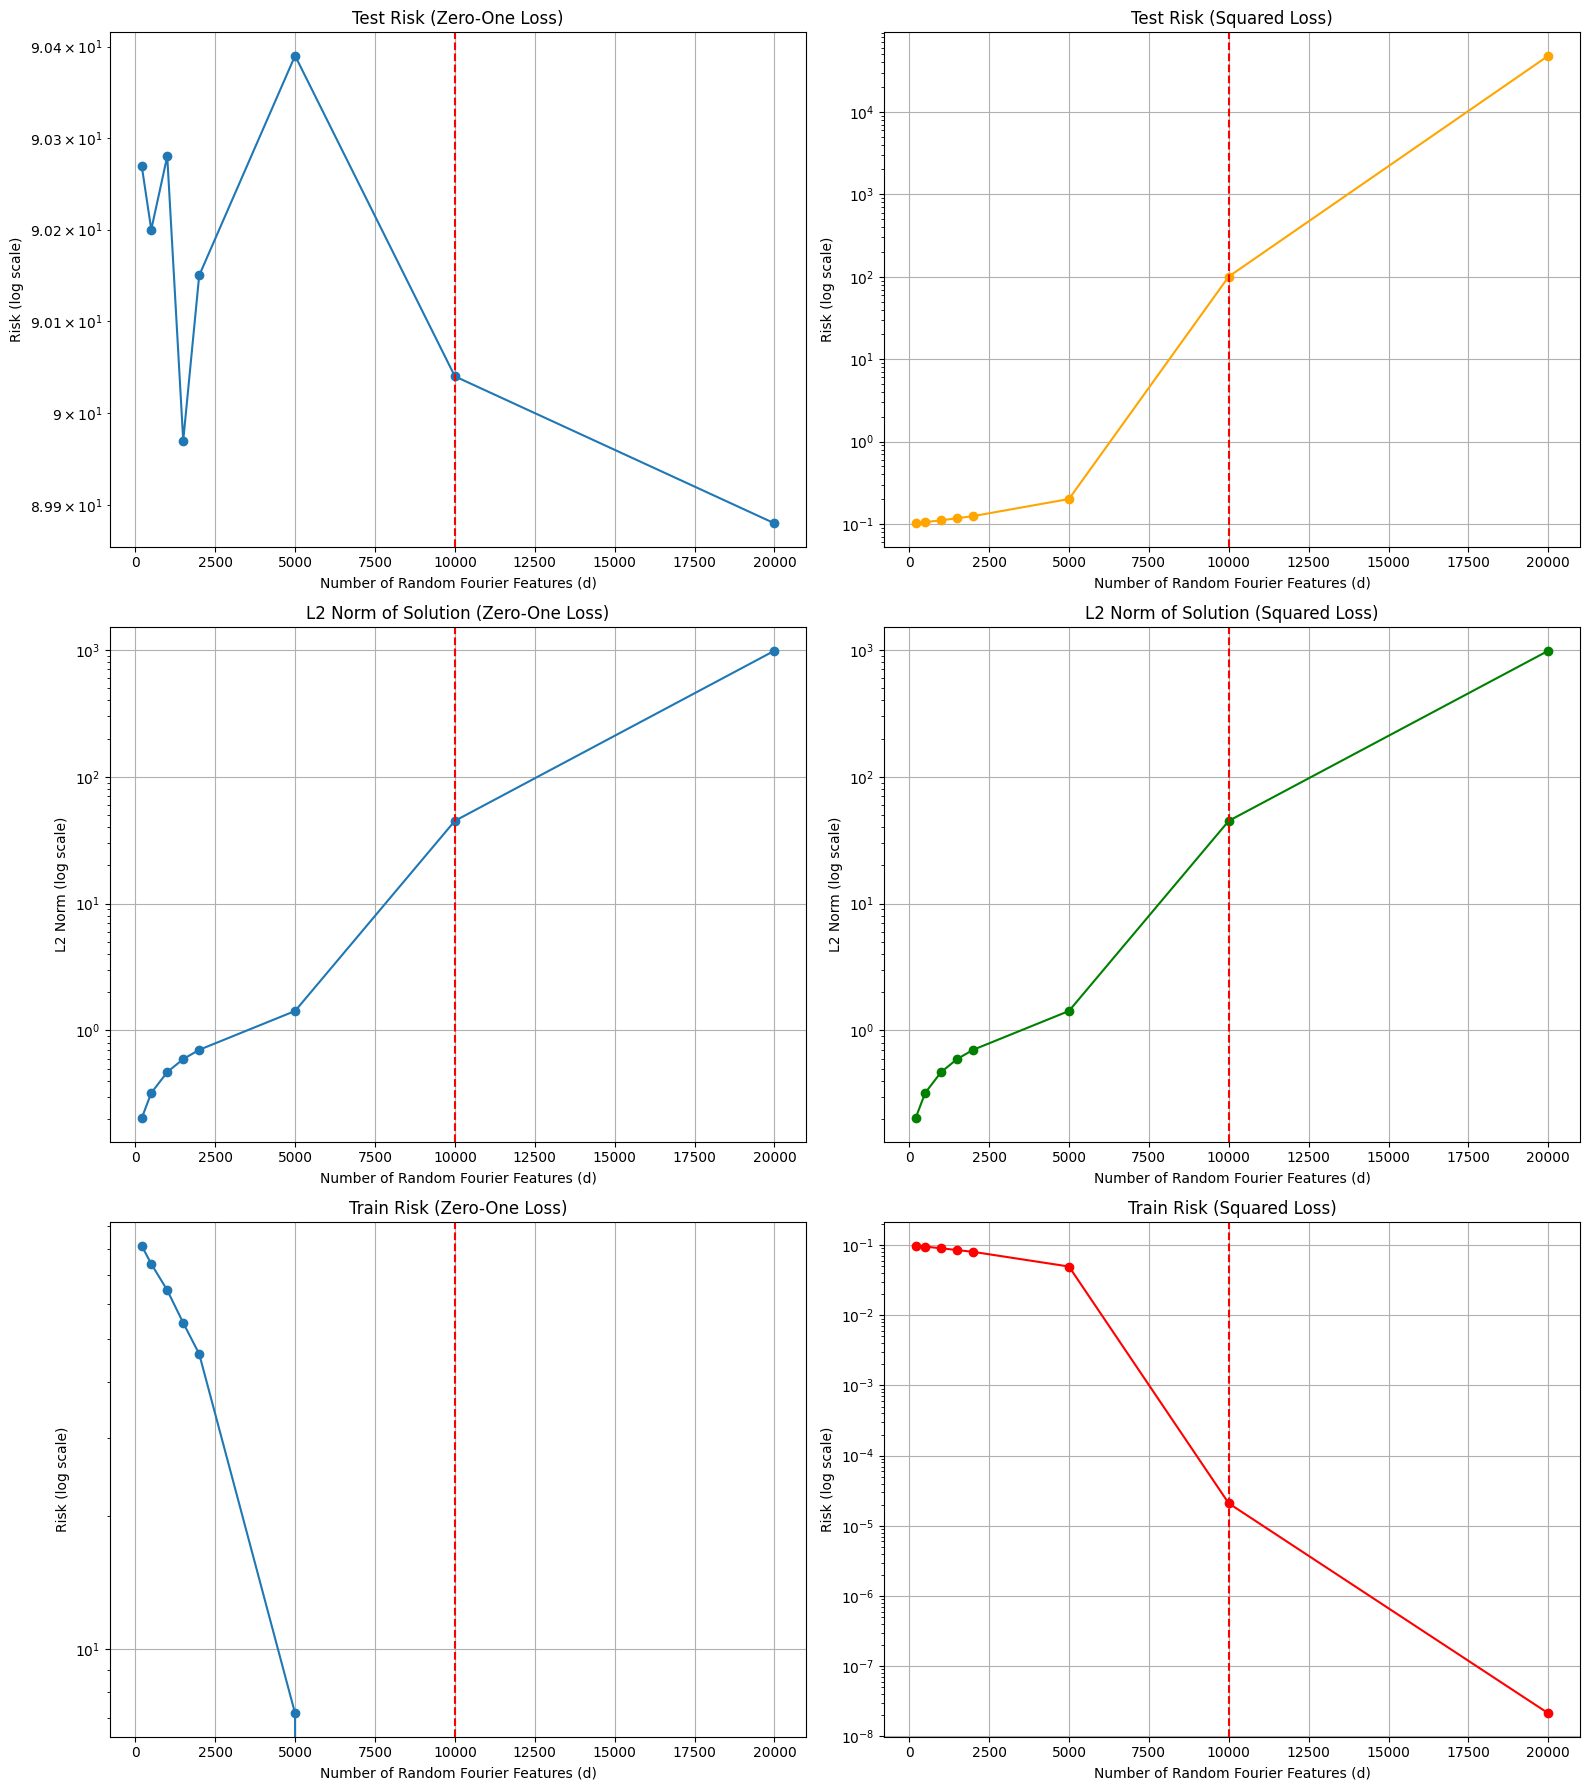

In [38]:
main()

In [39]:
display(sound)